# Gamestop Analysis

There was a big fuss earlier this year around Gamestop (GME). Retail traders taking on hedge funds, sticking it to the man!  Majority shareholder investment funds such as Black Rock and HFT firms executing the trades for platforms such as Robinhood did pretty well too... 🙈

Let's see how Twitter data correlates with GME prices over time and apply some NLP techniques to the Twitter data while we're at it 🤖

**In this notebook we will:**
- Download Gamestop price data using the yfinance library
- Download Twitter data using Twint
- Visualise GME price and Tweet volumes over time
- Analyse sentiment of Tweets
- Group similar tweets using Doc2Vec and k-means clustering

*Emojis courtesy of 👉: https://emojikeyboard.org/copy/Main_Page*

In [1]:
import cryptocompare
import datetime as dt
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import twint
import yfinance as yf
import nest_asyncio

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer

from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn.cluster import KMeans

pd.set_option('max_colwidth', 400)

%run "C:\Users\geoff\PycharmProjects\ml-utils\nlp_utils.py"
%run "C:\Users\geoff\PycharmProjects\ml-utils\monte_carlo_cv.py"
%run "C:\Users\geoff\PycharmProjects\db-utils\database_controller.py"
%run "C:\Users\geoff\PycharmProjects\ml-utils\ml_utils.py"

In [2]:
def get_stock_price_data(stocks, start_dt='2015-01-01', end_dt='2021-12-31'):
    """Get stock data from Yahoo Finance"""
    
    for i, stock in enumerate(stocks):
        try:
            _current_stock = yf.download(stock, start_dt, end_dt)
            _current_stock = _current_stock.reset_index()

            if i==0:
                all_stocks = pd.DataFrame()
                all_stocks['Date'] = _current_stock['Date']

            all_stocks[stock + '_close'] = _current_stock['Close']
            all_stocks[stock + '_volume'] = _current_stock['Volume']

            # Sleep in between calls
            time.sleep(0.5)
        except:
            print('Error retieving data for:', stock)

    return all_stocks


In [3]:
# Helper functions
def plot_price_data(df, var, date_var):
    """Plot price data"""

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f'{var} over time')
    ax.plot(df[date_var], df[var], label=var)
    plt.legend(loc='upper left', bbox_to_anchor=(0.0, -0.1), frameon=False)
    plt.show()

def plot_distribution(df, var):
    """Plot distribution of a variable"""

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f'{var} distribution')
    ax = sns.kdeplot(df[var], label=var, fill=True, alpha=0.25)
    plt.legend(loc='upper left', bbox_to_anchor=(0.0, -0.1), frameon=False)
    plt.show()        


### 1. Get GME price data 📈
First lets get the price data

In [4]:
# Get GME price data from the 1st of November 2020 until present
prices_df = get_stock_price_data(['GME'], start_dt='2021-01-01', end_dt='2021-12-31')

[*********************100%***********************]  1 of 1 completed


In [5]:
# Let's check our data
prices_df.head()

,Date,GME_close,GME_volume
0,2021-01-04,17.250000,10022500
1,2021-01-05,17.370001,4961500
2,2021-01-06,18.360001,6056200
3,2021-01-07,18.080000,6129300
4,2021-01-08,17.690001,6482000


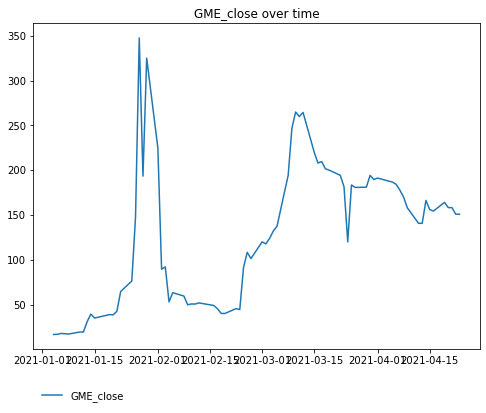

In [6]:
# Plot the prices
plot_price_data(prices_df, 'GME_close', 'Date')

### 2. Get Twitter data 🔊
Download data from Twitter using the twint library.

Let's get all the tweets that mention GME from the 1st of November 2020.

We will transform this data by counting the number of times GME is mentioned each day. We will then plot this against the price data.

In [7]:
nest_asyncio.apply()

def get_tweets(search, since, until, output=None, pandas_df=False, limit=None, username=None, verified=True, 
               hide_output=True, lang='en'):
    """
    Wrapper function to get tweets using the twint library
    """
    
    c = twint.Config()
    c.Search = search
    
    c.Since = since
    c.Until = until
    
    if limit is not None:
        c.Limit = limit
    
    if username is not None:
        c.Username = username
        
    c.Verified = verified
    c.Hide_output = hide_output
    c.Lang = lang
    c.Lower_case = True
    c.Count = True
    
    if output is not None:
        c.Store_csv = True
        c.Custom_csv = ['id', 'user_id', 'username', 'tweet']
        c.Output = output

    c.Pandas = pandas_df   
    
    # run search
    twint.run.Search(c)
    
    df = twint.storage.panda.Tweets_df
    
    if pandas_df:
        return twint.storage.panda.Tweets_df
    
    
def daily_tweet_counts(df):
    """
    Count the number of times that a term has been tweeted about within a day
    """
    
    # We only need the datetime and tweet fields
    df_tmp = df[['date', 'tweet']].copy()
    # Extract the data from the datetime
    df_tmp['date'] = df_tmp['date'].str[:10]
    df_tmp['tweet_count'] = 1
    
    # Aggregate number of tweets by hour
    tweets_agg = df_tmp.groupby('date').agg({'tweet_count':'sum'}).reset_index()
   
    return tweets_agg


In [8]:
# Get tweet data for selected coins and aggregate into hourly counts
coin = 'GME' 
since = '2021-01-01'
until = '2021-12-31'

tweets_df = get_tweets(coin, since, until, pandas_df=True, hide_output=True)

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 15173 Tweets.


In [9]:
# Get daily tweet counts
tweets_df_count = daily_tweet_counts(tweets_df)
tweets_df_count.head()

,date,tweet_count
0,2021-01-01,3
1,2021-01-02,2
2,2021-01-03,2
3,2021-01-04,2
4,2021-01-05,4


### 3. Merge data and plot 📊
In this section we will merge the price and tweets data.

We will then plot the data to understand how prices and tweet volumes move together.

In [10]:
# Create a string version of date as a merging key
prices_df['date_str'] = prices_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

# Merge data and clean 
merged_df1 = pd.merge(prices_df, tweets_df_count, how="left", left_on=prices_df['date_str'], 
                     right_on=tweets_df_count['date'])
merged_df1.drop(['key_0', 'date'], axis=1, inplace=True)
merged_df1.head()

,Date,GME_close,GME_volume,date_str,tweet_count
0,2021-01-04,17.250000,10022500,2021-01-04,2.0
1,2021-01-05,17.370001,4961500,2021-01-05,4.0
2,2021-01-06,18.360001,6056200,2021-01-06,7.0
3,2021-01-07,18.080000,6129300,2021-01-07,NaN
4,2021-01-08,17.690001,6482000,2021-01-08,1.0


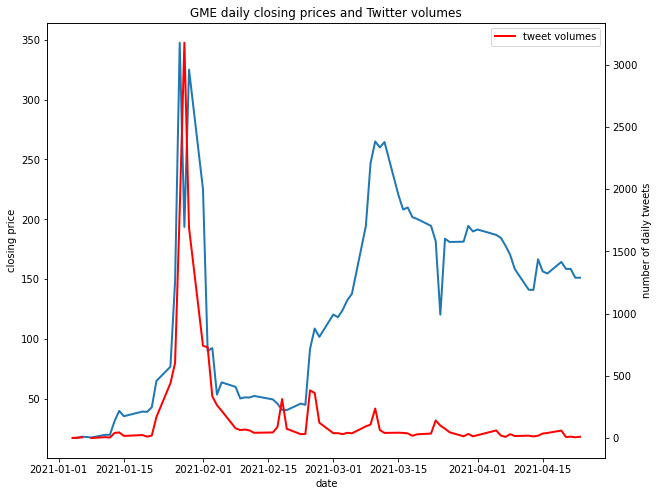

In [11]:
# Plot prices and tweet volumes
fig, ax =plt.subplots(figsize=(10, 8))
ax.set_title(f'GME daily closing prices and Twitter volumes')
ax2 = ax.twinx()
ax.plot(merged_df1['Date'], merged_df1['GME_close'], label='closing price', linewidth=2.0)
ax2.plot(merged_df1['Date'], merged_df1['tweet_count'], color='red', label='tweet volumes', linewidth=2.0)
ax.set_xlabel('date')
ax.set_ylabel('closing price')
ax2.set_ylabel('number of daily tweets')
plt.legend()
plt.show()

The initial price spike in January 2021 coincided with a significant increase in Twitter activity about GME.

Tweet volumes have been significantly more subdued for the later price rallies from March onwards.

### 4. Build Sentiment Model 🔨
In this section we will explore frequencies of unigrams, bigrams and trigrams and use NLTKs sentiment intensity analyser to classify sentiment over time. We will also examine the correlation between prices and sentiment.


In [12]:
# First let's clean the tweets
tweets_df_clean = clean_text_data(tweets_df, 'tweet')
tweets_df_clean = tweets_df_clean[['date', 'tweet']]
tweets_df_clean['date'] = tweets_df_clean['date'].str[:10]
tweets_df_clean.head()

,date,tweet
0,2021-04-24,earlier year army retail investors assembled rwsb financial elite weapons choice gme robinhoodapp ceo iamjohnegan explores internet mob movement forbes here httpstcoobbkjngxf
1,2021-04-23,bag getting little heavy officialwsb gme
2,2021-04-23,referg sunshinehappyp garyseconomics yes theyll lose falls it gme
3,2021-04-23,haydenkmac michaelahirsh dont believe so think start happened gme amc earlier year headlines worldwide got lot people personal investments aside k etc think continue build
4,2021-04-23,hcas dr michael cuffe spoke chipkahn gme programs hospitalsinfocus podcast check out httpstcoefgcmof


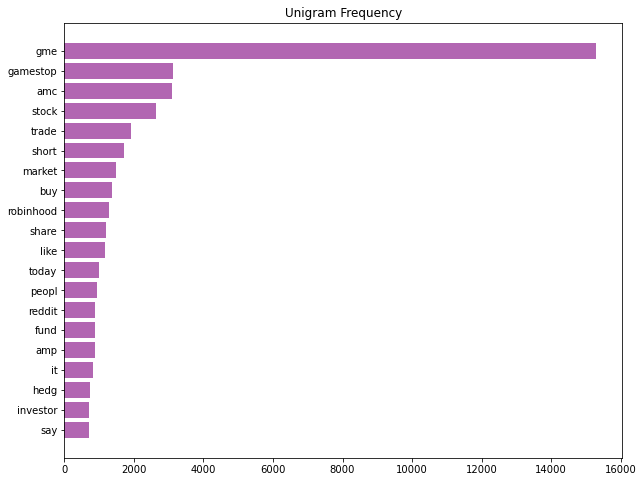

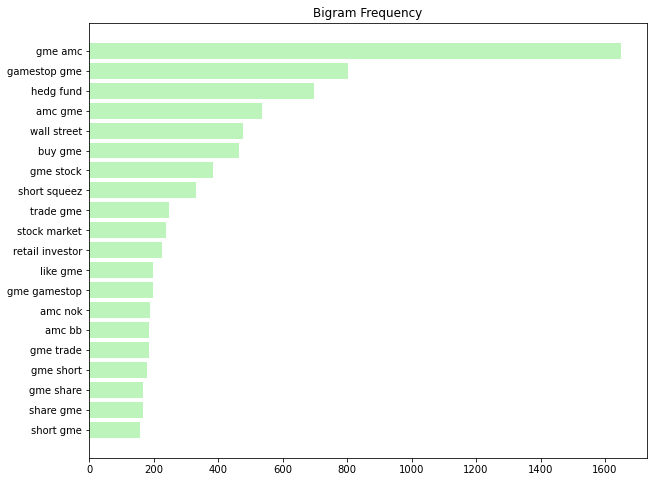

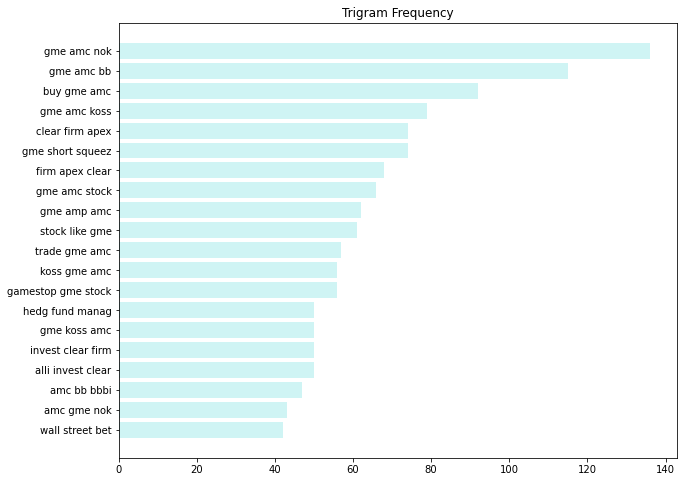

In [13]:
# Create bag of words models to produce unigrams, bigrams and trigrams
tweets_list = tweets_df_clean['tweet'].values.tolist()
tweets_stem = stem_docs(tweets_list)

vectorizer_unigram = CountVectorizer(ngram_range=(1, 1), max_features=100)
vectorizer_unigram.fit(tweets_stem)
tweets_unigram = vectorizer_unigram.transform(tweets_stem).toarray()

vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), max_features=100)
vectorizer_bigram.fit(tweets_stem)
tweets_bigram = vectorizer_bigram.transform(tweets_stem).toarray()

vectorizer_trigram = CountVectorizer(ngram_range=(3, 3), max_features=100)
vectorizer_trigram.fit(tweets_stem)
tweets_trigram = vectorizer_trigram.transform(tweets_stem).toarray()

# Plot bigram and trigram frequencies
plot_word_freq(tweets_unigram, vectorizer_unigram.get_feature_names(), n_words=20, 
               title='Unigram Frequency', color='purple')
plot_word_freq(tweets_bigram, vectorizer_bigram.get_feature_names(), n_words=20, 
               title='Bigram Frequency', color='lightgreen')
plot_word_freq(tweets_trigram, vectorizer_trigram.get_feature_names(), n_words=20, 
               title='Trigram Frequency', color='paleturquoise')

In [14]:
# Use the NLTK SentimentIntensityAnalyzer() to get the sentiment the tweets
sia = SentimentIntensityAnalyzer()
sentiment_list = []
for tweet in tweets_stem:
    sentiment_list.append(sia.polarity_scores(tweet))
    
sentiment_df = pd.DataFrame(sentiment_list)

In [15]:
# Merge cleaned tweet data with sentiment - we will use the compound field to gauge sentiment
sentiment_df_merged = pd.concat([tweets_df_clean, sentiment_df], axis=1)
sentiment_df_merged['positive'] = np.where(sentiment_df_merged['compound'] > 0.0, 1, 0)
sentiment_df_merged['negative'] = np.where(sentiment_df_merged['compound'] < 0.0, 1, 0)
sentiment_df_merged.head()

,date,tweet,neg,neu,pos,compound,positive,negative
0,2021-04-24,earlier year army retail investors assembled rwsb financial elite weapons choice gme robinhoodapp ceo iamjohnegan explores internet mob movement forbes here httpstcoobbkjngxf,0.095,0.905,0.000,-0.296,0,1
1,2021-04-23,bag getting little heavy officialwsb gme,0.000,1.000,0.000,0.000,0,0
2,2021-04-23,referg sunshinehappyp garyseconomics yes theyll lose falls it gme,0.218,0.565,0.218,0.000,0,0
3,2021-04-23,haydenkmac michaelahirsh dont believe so think start happened gme amc earlier year headlines worldwide got lot people personal investments aside k etc think continue build,0.000,1.000,0.000,0.000,0,0
4,2021-04-23,hcas dr michael cuffe spoke chipkahn gme programs hospitalsinfocus podcast check out httpstcoefgcmof,0.000,1.000,0.000,0.000,0,0


In [16]:
# Check how many positive tweets we have
sentiment_df_merged['positive'].value_counts()

0    9221
1    5952
Name: positive, dtype: int64

In [17]:
# Check how many negative tweets we have
sentiment_df_merged['negative'].value_counts()

0    11899
1     3274
Name: negative, dtype: int64

In [18]:
# Aggregate sentiment data and merge with price data
sentiment_df_agg = sentiment_df_merged.groupby('date').agg({'positive':'mean', 'negative':'mean'}).reset_index()
merged_df2 = pd.merge(merged_df1, sentiment_df_agg, how='left', left_on=merged_df1['date_str'], right_on=sentiment_df_agg['date'])
merged_df2.drop(['key_0'], axis=1, inplace=True)
merged_df2.head()

,Date,GME_close,GME_volume,date_str,tweet_count,date,positive,negative
0,2021-01-04,17.250000,10022500,2021-01-04,2.0,2021-01-04,0.000000,0.0
1,2021-01-05,17.370001,4961500,2021-01-05,4.0,2021-01-05,0.250000,0.0
2,2021-01-06,18.360001,6056200,2021-01-06,7.0,2021-01-06,0.285714,0.0
3,2021-01-07,18.080000,6129300,2021-01-07,NaN,NaN,NaN,NaN
4,2021-01-08,17.690001,6482000,2021-01-08,1.0,2021-01-08,0.000000,0.0


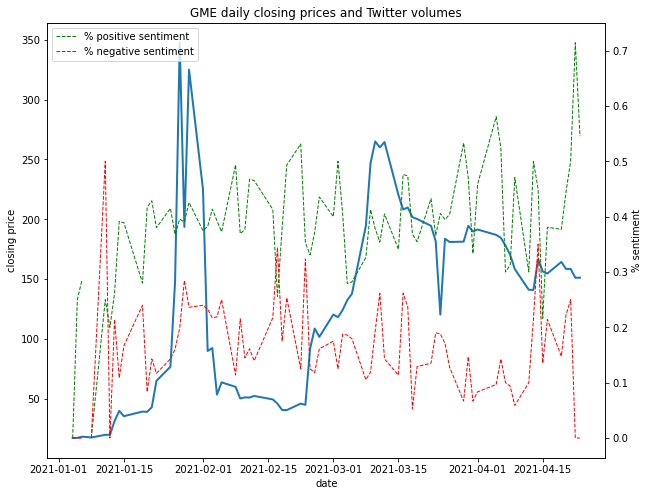

In [19]:
# Plot the prices versus positive and negative sentiment
fig, ax =plt.subplots(figsize=(10, 8))
ax.set_title(f'GME daily closing prices and Twitter volumes')
ax2 = ax.twinx()
ax.plot(merged_df2['Date'], merged_df2['GME_close'], label='closing price', linewidth=2.0)
ax2.plot(merged_df2['Date'], merged_df2['positive'], color='green', label='% positive sentiment', linewidth=1.0,
         linestyle='--')
ax2.plot(merged_df2['Date'], merged_df2['negative'], color='red', label='% negative sentiment', linewidth=1.0,
         linestyle='--')
ax.set_xlabel('date')
ax.set_ylabel('closing price')
ax2.set_ylabel('% sentiment')
plt.legend()
plt.show()

Positive sentiment appears stable over the sample and is consistently higher than negative sentiment.

Negative sentiment appears to be decreasing slightly over most of the sample and increasing in April.

In [20]:
# Check correlations
merged_df2[['GME_close', 'positive', 'negative']].corr()

,GME_close,positive,negative
GME_close,1.000000,0.294989,0.044581
positive,0.294989,1.000000,0.063180
negative,0.044581,0.063180,1.000000


Checking correlations we see there is a weak positive correlation between closing prices and positive sentiment

### 5. Document Vectors

As a final step, let's transform the tweets into document vectors and apply k-means clustering in order to produce groups that are similar across document vector dimensions.

#### Doc2Vec
Building on the foundations of Word2Vec (Mitkolov et al., 2013), Doc2Vec is an unsupervised learning algorithm which generates densely populated, fixed-length feature representations from documents of varying lengths (Le and Mitkolov, 2014). 

The vector representations are trained to predict the surrounding words in various contexts sampled from the documents. These vector representations are learned via a shallow neural network.

Doc2Vec improves on the shortcomings of bag of words models in several ways: documents can be represented in fewer dimensions, vectors are densely populated and documents with similar meanings share a similar vector space.

#### Training a Doc2Vec model
We will train a Doc2Vec model using Gensim's Doc2Vec implementation and use the following hyperparameter settings as suggested by Lau and Baldwin (2016):
- dm: 0 (use distributed bag of words algorithm instead of distributed memory)
- vector size: 300
- window size: 15
- min count: 5
- sub-sample: 10e-5
- epochs: 20
- alpha: 0.025

In [21]:
# Tag tweets and build a Doc2Vec model
tweets_list = tweets_df_clean['tweet'].values.tolist()
tweets_tagged = label_sentences(tweets_list, 'Train')
d2v_model = Doc2Vec(dm=0, vector_size=300, window=15, min_count=5, 
                    sample=10e-5, alpha=0.025, epochs=20)
d2v_model.build_vocab(tweets_tagged)
d2v_model.train(tweets_tagged, total_examples=len(tweets_tagged), epochs=d2v_model.epochs)

d2v_vectors_dbow = get_vectors(d2v_model, tweets_tagged)

In [22]:
# Create clusters
n_clusters = 4

clf = KMeans(n_clusters=n_clusters)
clf.fit(d2v_vectors_dbow)
clusters = clf.predict(d2v_vectors_dbow)

In [23]:
# Add clusters to df
tweets_df_clean['cluster'] = clusters
tweets_df_clean.head()

,date,tweet,cluster
0,2021-04-24,earlier year army retail investors assembled rwsb financial elite weapons choice gme robinhoodapp ceo iamjohnegan explores internet mob movement forbes here httpstcoobbkjngxf,1
1,2021-04-23,bag getting little heavy officialwsb gme,3
2,2021-04-23,referg sunshinehappyp garyseconomics yes theyll lose falls it gme,3
3,2021-04-23,haydenkmac michaelahirsh dont believe so think start happened gme amc earlier year headlines worldwide got lot people personal investments aside k etc think continue build,3
4,2021-04-23,hcas dr michael cuffe spoke chipkahn gme programs hospitalsinfocus podcast check out httpstcoefgcmof,1


In [24]:
# Check volumes of the clusters
tweets_df_clean['cluster'].value_counts()

3    6061
1    6055
0    2181
2     876
Name: cluster, dtype: int64

**What do these clusters mean?**

Let's check 10 examples of each cluster

In [25]:
# Check cluster examples
for i in range(n_clusters):
    print(f'Cluster {i}')
    display(tweets_df_clean[tweets_df_clean['cluster']==i][['date', 'tweet']][:10])
    print()

Cluster 0


,date,tweet
13,2021-04-22,dogshill exactly time gme
27,2021-04-21,gamestop stock going up read optocmc feature here httpstcohobwsavjgq gme
31,2021-04-20,cash money gamestop whowantstobeamillionaire stonks gme tothemoon
46,2021-04-19,check gme today min markers close
57,2021-04-19,gamestop shares respond ceo shakeup gme httpstcotqxyiwnovm httpstcoqgxairja
58,2021-04-19,buy sell gamestop stock right now heres ibd analysis stock chart shows gme stocks stockstowatch gamestop httpstcoyngoezaib
62,2021-04-19,josephvvallace teslamaster doge amp gme up im happy camper
65,2021-04-19,gme gme things
72,2021-04-19,rstubenrauch setharichardson thinking bad gme bet
76,2021-04-19,gme way premarket httpstcohqarkcthi



Cluster 1


,date,tweet
0,2021-04-24,earlier year army retail investors assembled rwsb financial elite weapons choice gme robinhoodapp ceo iamjohnegan explores internet mob movement forbes here httpstcoobbkjngxf
4,2021-04-23,hcas dr michael cuffe spoke chipkahn gme programs hospitalsinfocus podcast check out httpstcoefgcmof
6,2021-04-23,aaronmedo hello time received information regarding this available listed account gt history statements gt shareholder library reach gmes investor relations information jd
7,2021-04-23,millennials make reality runaway winners year far worlds popular stock index sampp brand new holdings them too insights datatrek apexclearing gme amc httpstcozhfhdnarb
8,2021-04-23,mcavaliere malcolmxon truewe likely spac heres detailed revenue guidance interested buying amc gme httpstcodyqozdwac
9,2021-04-23,csymrl titonka really hamper gme speculation main driver economy imo
11,2021-04-23,bankofamerica michael hartnett best latest flows events dear boy events credit events gme greensill archegos increasing frequency speculation conviction dangerously highxbt spacs ipos nfts coin fomoif signs
12,2021-04-22,heard gme lately hope theres bag holders huge dip
14,2021-04-22,kieth gill aka roaring kitty exercised coveted gamestop options giving possession additional shares wasnt enough gill picked shares bringing total ownership more m gme stocks httpstcohtivmysyl
16,2021-04-22,gains gamestop gme amp profit chris prybal senior market strategist schaeffers investment research bz conference track httpstcoqedrruga smallcapstocks httpstcoeufrbvmule



Cluster 2


,date,tweet
114,2021-04-17,pompey gme started mk dons httpstcopdypdprt
118,2021-04-16,frankwweclown gme fam
127,2021-04-16,dailylevels gme day
129,2021-04-16,woops gme
228,2021-04-13,brownmoneydoll amc gme lol
230,2021-04-12,gme
239,2021-04-12,gme
244,2021-04-12,gme httpstcovnbrhub
256,2021-04-10,gme
262,2021-04-09,ouch gme httpstcobomhdoykp



Cluster 3


,date,tweet
1,2021-04-23,bag getting little heavy officialwsb gme
2,2021-04-23,referg sunshinehappyp garyseconomics yes theyll lose falls it gme
3,2021-04-23,haydenkmac michaelahirsh dont believe so think start happened gme amc earlier year headlines worldwide got lot people personal investments aside k etc think continue build
5,2021-04-23,got talk natzhang gme hedge fund positioning big wakeup cool deep dive memes turn wall street upside httpstcofoxbwzgq
10,2021-04-23,ilovegamestop intelgaming razer gamestop do plus im supporter gme
15,2021-04-22,happens money robinhood goes under takes meme stock gme dogecoin httpstcofexitjy
18,2021-04-22,gamestop ceo gets m quitting job buying gme thank crazy
32,2021-04-20,gme short bn m shares shorted si float s si float fee shares shorted million shares worth million week shorts bn marktomarket losses mm todays httpstcokaspfkugw
33,2021-04-20,filljoyner guess roll profits gme now
35,2021-04-20,its extension phenomenon led tesla stock valued fundamentals recently gme gamestop short squeeze said chainyoda gimme dogecoin lambo dogeday said twitter user httpstcozfrtieer


After reviewing some examples of the clusters it looks like the tweets have been grouped together by tweet length!
Not really a useful outcome, we could have computed the tweet lengths directly. We will roll with it for now.

Let's create some names for the clusters, create new variables for each cluster and plot the results.

In [26]:
cluster_names = ['minimalist tweets', 'brief thoughts 1', 'in-depth analysis', 'brief thoughts 2']

# Create a new variable for each cluster
for i in range(n_clusters):
    tweets_df_clean['cluster_' + str(i)] = np.where(tweets_df_clean['cluster'] == i, 1, 0)
    
tweets_df_clean.head()

,date,tweet,cluster,cluster_0,cluster_1,cluster_2,cluster_3
0,2021-04-24,earlier year army retail investors assembled rwsb financial elite weapons choice gme robinhoodapp ceo iamjohnegan explores internet mob movement forbes here httpstcoobbkjngxf,1,0,1,0,0
1,2021-04-23,bag getting little heavy officialwsb gme,3,0,0,0,1
2,2021-04-23,referg sunshinehappyp garyseconomics yes theyll lose falls it gme,3,0,0,0,1
3,2021-04-23,haydenkmac michaelahirsh dont believe so think start happened gme amc earlier year headlines worldwide got lot people personal investments aside k etc think continue build,3,0,0,0,1
4,2021-04-23,hcas dr michael cuffe spoke chipkahn gme programs hospitalsinfocus podcast check out httpstcoefgcmof,1,0,1,0,0


In [27]:
# Aggregate data to get cluster volumes per day
clusters_agg = tweets_df_clean.groupby('date').agg({'cluster_0':'sum', 
                                                    'cluster_1':'sum',
                                                    'cluster_2':'sum',
                                                    'cluster_3':'sum'}).reset_index()
clusters_agg.head()

,date,cluster_0,cluster_1,cluster_2,cluster_3
0,2021-01-01,2,1,0,0
1,2021-01-02,1,1,0,0
2,2021-01-03,2,0,0,0
3,2021-01-04,1,1,0,0
4,2021-01-05,0,4,0,0


In [28]:
# Merge data
merged_df3 = pd.merge(merged_df2, clusters_agg, how='left', left_on=merged_df2['date_str'], right_on=clusters_agg['date'])
merged_df3.drop(['key_0'], axis=1, inplace=True)
merged_df3.head()

,Date,GME_close,GME_volume,date_str,tweet_count,date_x,positive,negative,date_y,cluster_0,cluster_1,cluster_2,cluster_3
0,2021-01-04,17.250000,10022500,2021-01-04,2.0,2021-01-04,0.000000,0.0,2021-01-04,1.0,1.0,0.0,0.0
1,2021-01-05,17.370001,4961500,2021-01-05,4.0,2021-01-05,0.250000,0.0,2021-01-05,0.0,4.0,0.0,0.0
2,2021-01-06,18.360001,6056200,2021-01-06,7.0,2021-01-06,0.285714,0.0,2021-01-06,1.0,5.0,0.0,1.0
3,2021-01-07,18.080000,6129300,2021-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-08,17.690001,6482000,2021-01-08,1.0,2021-01-08,0.000000,0.0,2021-01-08,0.0,1.0,0.0,0.0


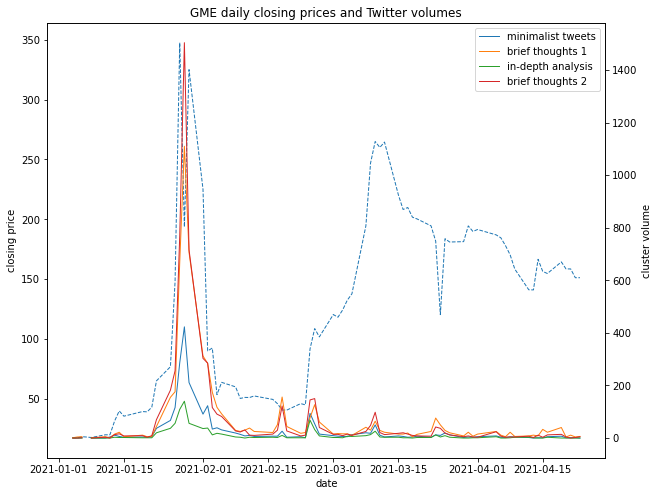

In [29]:
# Plot the prices versus cluster volumes
fig, ax =plt.subplots(figsize=(10, 8))
ax.set_title(f'GME daily closing prices and Twitter volumes')
ax2 = ax.twinx()
ax.plot(merged_df3['Date'], merged_df3['GME_close'], label='closing price', linewidth=1.0, linestyle='--')
for i in range(n_clusters):
    ax2.plot(merged_df3['Date'], merged_df3['cluster_' + str(i)], label=cluster_names[i], linewidth=1.0)

ax.set_xlabel('date')
ax.set_ylabel('closing price')
ax2.set_ylabel('cluster volume')
plt.legend()
plt.show()

### 6. References

Mikolov, T., Chen, K., Corrado, G. & Dean J. (2013). Efficient Estimation of Word Representations in Vector Space. Google. Retrieved from https://arxiv.org/pdf/1301.3781.pdf

Le, Q. & Mikolov, T. (2014). Distributed Representations of Sentences and Documents. In Proceedings of the 31st International Conference on Machine Learning, Beijing, China. Retrieved from https://arxiv.org/pdf/1405.4053.pdf

Lau, J. H. & Balwin, T. (2016). An Empirical Evaluation of doc2vec with Practical Insights into Document Embedding Generation. In Proceedings of the 1st Workshop on Representation Learning for NLP, 78–86. Retrieved from https://www.aclweb.org/anthology/W16-1609.pdf